In [1]:
import numpy as np
import PIL
import torch
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from loaders import *
import matplotlib.pyplot as plt
import glob
from model_evaluator import *
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

path = '/home/syl/Documents/Project/prob_reg/download/images/test_MixMNIST_07_15_2020_17_41/'
save_path = '/home/syl/Documents/Project/prob_reg/images/Toshow/MixMNIST_supp/'
dataset = MixMNIST('/home/syl/Documents/Project/prob_reg/dataset/MNIST', 'test')
font = ImageFont.truetype("/home/syl/Documents/Doc/open-sans/OpenSans-Bold.ttf", size=20)
os.makedirs(save_path, exist_ok=True)

test_files = glob.glob(path+"*prob.npy")
mode_stat = np.zeros([4, 5])
# mode_collection = dict()
prob_data = []
mode_type_data = []
print(len(test_files))




=> Dataset contains 10000 images
101


In [3]:

for file in test_files:
# file = test_files[0]
    prob = np.load(file)
#     print(prob)
    results = np.load(file.replace("prob.npy", "sample_labelIds.npy"))[:,None,...]
    # print(results.shape)

    img_key = os.path.basename(file).replace("_11prob.npy", "")
    #     print(img_key)
    mode_type = int(img_key[0])
    gt_modes = dataset.get_gt_modes(img_key)[:,None,None,...]

    d_matrix = get_energy_distance_components(gt_modes, results, 1)
    sample_mode = np.argmin(d_matrix['YS'], axis=0)
    tmp_mode_stat = np.zeros(4)
    for i in range(11):
        mode_stat[mode_type][sample_mode[i]] += prob[i]
        tmp_mode_stat[sample_mode[i]] += prob[i]
        
#     mode_collection.setdefault(mode_type, []).append(tmp_mode_stat)
    mode_type_data.extend(np.array([0,1,2,3]) + mode_type * 4)
    prob_data.extend(tmp_mode_stat)
    mode_stat[mode_type][4] += 1

print(mode_stat[:,:4] / np.tile(mode_stat[:,4, None], (1,4)))

[[0.24385649 0.25869924 0.23948416 0.25796012]
 [0.10254242 0.39414848 0.09782964 0.40547945]
 [0.29263891 0.5031852  0.0964569  0.10771899]
 [0.10075382 0.10249248 0.09929364 0.69746005]]


In [3]:
gt_prob = [0.25, 0.25, 0.25, 0.25, \
          0.1, 0.4, 0.1, 0.4, \
          0.3, 0.5, 0.1, 0.1, \
          0.1, 0.1, 0.1, 0.7]
gt_mode_label = range(16)

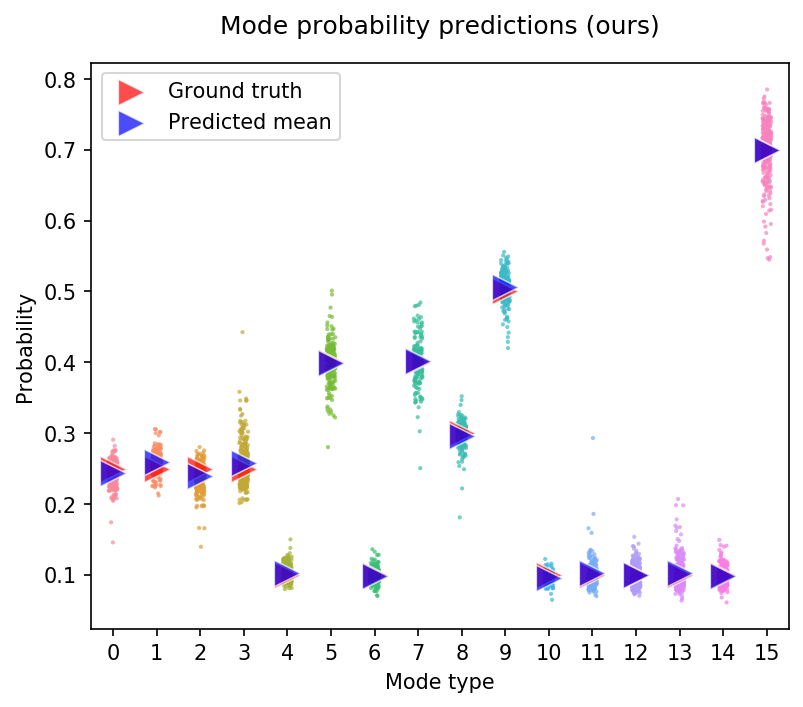

In [88]:
mean_mode_stat = mode_stat[:,:4] / np.tile(mode_stat[:,4, None], (1,4))
probplot = pd.DataFrame(data={'Probability': prob_data, 'Mode type': mode_type_data})
gtplot = pd.DataFrame(data={'Probability': gt_prob, 'Mode type': gt_mode_label})
meanplot = pd.DataFrame(data={'Probability': mean_mode_stat.reshape(-1), 'Mode type': gt_mode_label,\
                             })
# f = plt.figure(figsize=(5,5), dpi=150)
# gs = gridspec.GridSpec(1,1)
# ax = plt.subplot(gs[0,0])
f, ax = plt.subplots(1,1,figsize=(6,5),dpi=150)
sns.scatterplot(x="Mode type", y="Probability", data=gtplot, alpha=0.7, s=160, marker='>', color='r',ax=ax, label="Ground truth", zorder=10)
sns.scatterplot(x="Mode type", y="Probability", data=meanplot, alpha=0.7, s=160, marker='>', color='b',ax=ax,label="Predicted mean", zorder=10)

sns.stripplot(x="Mode type", y="Probability", data=probplot, alpha=0.7, s=2, ax=ax)

ax.set_title('Mode probability predictions (ours)', y=1.03)
ax.legend()

In [89]:

f.savefig(save_path + 'prob_stat.png')

In [4]:
# print(sample_mode)
# print(prob_mode)

In [2]:
sample_num = 6
gt_prob = [0.25, 0.25, 0.25, 0.25, \
          0.1, 0.4, 0.1, 0.4, \
          0.3, 0.5, 0.1, 0.1, \
          0.1, 0.1, 0.1, 0.7]
gt_mode_label = range(16)
os.makedirs(save_path, exist_ok=True)
for file in test_files[:100]:
# file = test_files[0]
    probs = np.load(file)
#     print(prob)
    samples = np.load(file.replace("prob.npy", "sample_labelIds.npy"))
    # print(results.shape)
    

    img_key = os.path.basename(file).replace("_11prob.npy", "")
    #     print(img_key)
    mode_type = int(img_key[0])
    input_gt_prob = gt_prob[mode_type*4 : mode_type*4 + 4]
    inputs = dataset.get_gt_modes(img_key).sum(axis=0) * 255.
    inputs = Image.fromarray(inputs).resize((184*4, 184))
    
    draw = ImageDraw.Draw(inputs)
    draw.text((0, 0),"{:.2f}".format(input_gt_prob[0]),255,font=font)
    draw.text((184, 0),"{:.2f}".format(input_gt_prob[1]),255,font=font)
    draw.text((184*2, 0),"{:.2f}".format(input_gt_prob[2]),255,font=font)
    draw.text((184*3, 0),"{:.2f}".format(input_gt_prob[3]),255,font=font)


    data_arr = np.array(inputs)/255.

    sample_arr_col = []

    for i in range(sample_num):
        
        sample = samples[i,0,...]*255.
        sample = Image.fromarray(sample).resize((184*4, 184))
        prob = probs[i]
    #     print(prob)
        draw = ImageDraw.Draw(sample)
        draw.text((0, 0),"{:.4f}".format(prob),255,font=font)
        sample = np.array(sample)/255.
        
        sample_arr_col.append(sample)


    final_image = np.concatenate([data_arr, *sample_arr_col], axis=0)
    # fig = plt.figure(figsize = (10,10)) 
    # plt.imshow(final_image, cmap='gray')
    # plt.show()
    
    plt.imsave(save_path + '{}_{}sample.png'.format(img_key, sample_num), final_image, cmap='gray')

In [3]:

plt.imsave(save_path + '{}_{}sample.png'.format(img_key, sample_num), final_image, cmap='gray')